In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from scipy import stats
%matplotlib inline

# Initialisation
## Données

In [3]:
seuil_detection_fitness=0.005

def analyse_ligne(row): 
    res=[]
    for i in range(int(len(row)/3-1)):
        if(row[3*i+2]!="NA"):
            nouv=float(row[3*i+2].replace(",","."))
            if nouv<seuil_detection_fitness: nouv=0
            res+=[nouv]
        else:
            res+=[-1] # JJ   attention, pb à régler un jour!
    return res

def analyse_fichier(): # ressort [W_t pour tout t] pour le fichier lu
    wt_tot=[]
    wt_cur=[]
    with open("doi_10/All_data/data_microMA/dataset_microMA_MutH.csv", newline='') as csvfile:
        reader=csv.reader(csvfile,delimiter=';')
        nrow=0
        for row in reader:
            if(nrow>=2):
                wt_cur=analyse_ligne(row)
                wt_tot+=[wt_cur]
            nrow+=1
    return wt_tot


In [4]:
wt_real=np.array(analyse_fichier())
wt_real=wt_real[3:,:] # il faut supprimer les deux 1res.
with open('growthR_sim.npy', 'rb') as f:
    wt_sim = np.load(f)
with open('growthR_sim_noisy.npy', 'rb') as f:
    wt_sim_noise = np.load(f)

La fonction suivante pose parfois des problèmes pour les données observées (trop de bruit ?)

In [5]:
def normalise(wt_init): # renvoie Wt/W0 pour que toutes les cellules partent du même taux de croissance
    wt=wt_init.copy()
    for i in range(len(wt[0,:])):
        if(wt[0,i]!=0):
            wt[:,i]=wt[:,i]/wt[0,i]
        else:
             wt[:,i]=wt[:,i]*0
    return wt

def normalise2(wt_init,n): # renvoie Wt/moyenne(W0:Wn) pour que toutes les cellules partent presque du même taux de croissance et que ce soit lisse !
    wt=wt_init.copy()
    for i in range(len(wt[0,:])):
        nm=np.mean(wt[0:n,i])
        if(nm!=0):
            wt[:,i]=wt[:,i]/nm
        else:
             wt[:,i]=0
    return wt

## Fonctions générales

In [6]:
def fourier_inverse_old(x,xi,Ff):
    res=[]
    n=len(Ff)
    for xp in x:
        fx=0
        for i in range(n):
            fx+=Ff[i]*np.exp(1j*xp*xi[i])
        res+=[fx/(n*2*np.pi)]
    return res

def get_fourier_wt_old(xi,wt):
    res=[]
    n=len(wt)
    for xip in xi:
        Ffx=0
        for i in range(n):
            if(wt[i]>0.001):
                Ffx+=np.exp(-1j*xip*(wt[i]))
        res+=[Ffx/n]
    return res

def get_fourier_log_wt_old(xi,wt):
    res=[]
    n=len(wt)
    for xip in xi:
        ntot=0
        Ffx=0
        for i in range(n):
            if(wt[i]>0):
                Ffx+=np.exp(-1j*xip*np.log(wt[i]))
                ntot+=1
        res+=[Ffx/ntot]
    return res

In [7]:
def fourier_inverse0(X,Xi,F_Xi):  # ???
    return [np.mean(F_Xi*np.exp(1j*x*Xi))/(2*np.pi) for x in X]

def fourier_inverse(X,Xi,F_Xi):  # ???
    return [(Xi[1]-Xi[0])*np.sum(F_Xi*np.exp(1j*x*Xi))/(2*np.pi) for x in X]

def get_fourier_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*Wt[Wt>0])) for xi in Xi]

def get_fourier_log_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*np.log(Wt[Wt>0]))) for xi in Xi]

In [8]:
def draw_log_log(wt,ximin,ximax,nbreaks_xi,tmax,titre=""):
    tot=[]
    tot_tmp=[]
    xi=np.linspace(ximin,ximax,nbreaks_xi)
    for t in range(tmax):
        #tot+=[np.log(np.abs(np.array(Fu_t))]
        Fu_t=get_fourier_log_wt(xi,wt[t])
        tot_tmp+=[np.array(Fu_t)]
    tot_tmp=np.array(tot_tmp)
    for i in range(len(tot_tmp[0,:])):
        tot_tmp[:,i]=tot_tmp[:,i]/tot_tmp[0,i]
    tot=np.log(np.abs(tot_tmp))
    tot=np.array(tot)
    # régression linéaire:
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot)[:,k])
        plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        print("pente :",slope)
    # affichage:
    plt.plot(range(tmax),tot)
    plt.grid()
    plt.legend(["xi="+str(xip) for xip in xi])
    plt.xlabel("t")
    plt.ylabel("ln[Fu_t(xi)]")
    plt.title(titre)
    plt.show() 

def draw_log_arg(wt,ximin,ximax,nbreaks_xi,tmax,titre=""):
    tot=[]
    tot_tmp=[]
    xi=np.linspace(ximin,ximax,nbreaks_xi)
    for t in range(tmax):
        #tot+=[np.log(np.abs(np.array(Fu_t))]
        Fu_t=get_fourier_log_wt(xi,wt[t])
        tot_tmp+=[np.array(Fu_t)]
    tot_tmp=np.array(tot_tmp)
    for i in range(len(tot_tmp[0,:])):
        tot_tmp[:,i]=tot_tmp[:,i]/tot_tmp[0,i]
    tot=np.angle(tot_tmp)
    tot=np.array(tot)
    # régression linéaire:
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot)[:,k])
        plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        print("pente :",slope)
    # affichage:
    plt.plot(range(tmax),tot)
    plt.grid()
    plt.legend(["xi="+str(xip) for xip in xi])
    plt.xlabel("t")
    plt.ylabel("arg[Fu_t(xi)]")
    plt.title(titre)
    plt.show() 

In [9]:
wt_sim_norm=normalise(wt_sim)
wt_real_norm=normalise(wt_real)

# Estimation de $a_{\xi}$


## Travail sur l'estimation de $\Re(a_{\xi})$

pente : -2.0876397401286925e-07
pente : -8.418200438579364e-06
pente : -2.6635437864297783e-05
pente : -5.0371991716768753e-05
pente : -7.406708888274159e-05
pente : -9.283284802132874e-05
pente : -0.00010402216125890605
pente : -0.00010802837041388624
pente : -0.00010799886671738827
pente : -0.00010860603227424687


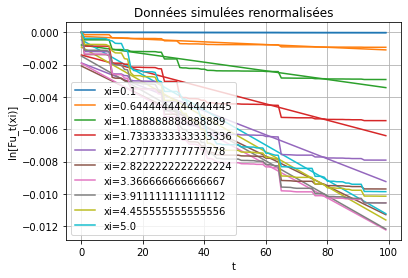

pente : -2.632556306317597e-07
pente : -9.959131371887953e-06
pente : -2.7826542063038452e-05
pente : -4.952566471934375e-05
pente : -7.215385402355856e-05
pente : -9.050487110216922e-05
pente : -0.00010349466226415772
pente : -0.00010555609975096244
pente : -0.00010333362283867001
pente : -0.00010240403746214466


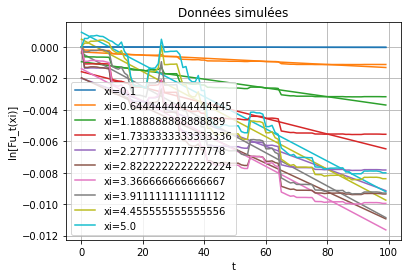

In [10]:
draw_log_log(wt_sim_norm,ximin=0.1,ximax=5,nbreaks_xi=10,tmax=100,titre="Données simulées renormalisées")
draw_log_log(wt_sim,ximin=0.1,ximax=5,nbreaks_xi=10,tmax=100,titre="Données simulées")

$\to$ les formes et les pentes sont similaires !

pente : -0.00010860603227424687
pente : -0.00013405448698711203
pente : -0.0001978040745818948
pente : -0.0002599790077806779
pente : -0.0002860657040815024


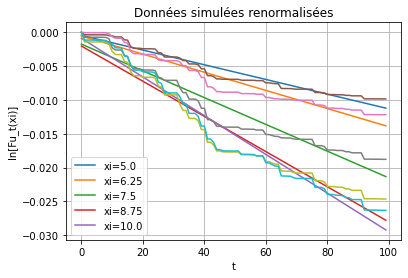

pente : -0.00010240403746214466
pente : -0.00013130962976932607
pente : -0.00022227087963207998
pente : -0.0003323492330204516
pente : -0.00037392533529743586


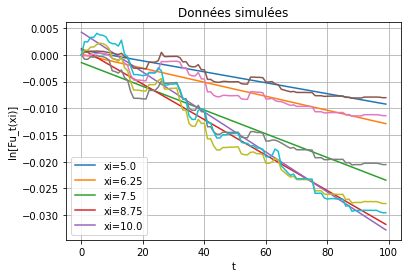

In [11]:
draw_log_log(wt_sim_norm,ximin=5,ximax=10,nbreaks_xi=5,tmax=100,titre="Données simulées renormalisées")
draw_log_log(wt_sim,ximin=5,ximax=10,nbreaks_xi=5,tmax=100,titre="Données simulées")

$\to$ la similarité est moins bonne quand $\xi$ augmente.

pente : -0.0002860657040815024
pente : -0.00036182433828332096
pente : -0.00044755258454908897
pente : -0.0004966827468853559
pente : -0.00045561058359208623


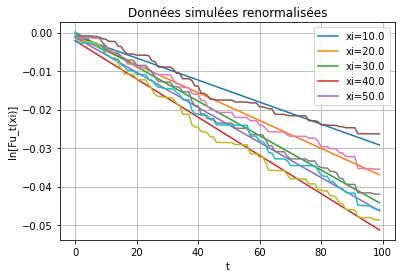

pente : -0.00037392533529743586
pente : -0.00033792980547236263
pente : -0.0030697979660868004
pente : -0.003444952437791581
pente : -0.0009232364494378412


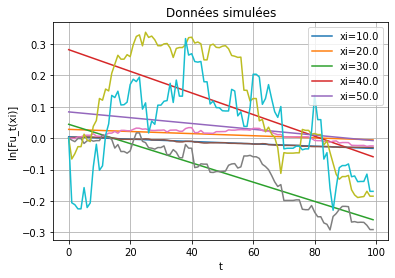

In [12]:
draw_log_log(wt_sim_norm,ximin=10,ximax=50,nbreaks_xi=5,tmax=100,titre="Données simulées renormalisées")
draw_log_log(wt_sim,ximin=10,ximax=50,nbreaks_xi=5,tmax=100,titre="Données simulées")

$\to$ les données non-renormalisées ne sont pas des droites : pourquoi ?

$\to$ les pentes n'ont plus de sens.

## Travail sur l'estimation de $\Im(a_{\xi})$

pente : 7.864012826725868e-06
pente : 4.9113184789463356e-05
pente : 8.398037109697793e-05
pente : 0.00010900707441742072
pente : 0.00012362667397986237
pente : 0.0001303052203342919
pente : 0.0001336663132080293
pente : 0.0001388585872498853
pente : 0.00014977207996363188
pente : 0.00016777741644190643


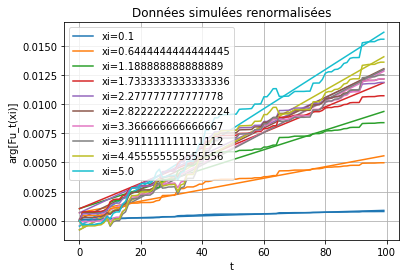

pente : 1.008485384795855e-05
pente : 6.18966504368158e-05
pente : 0.00010434936042162664
pente : 0.00013780619723790583
pente : 0.00015983987486217522
pente : 0.0001729421612761955
pente : 0.00017844129580744068
pente : 0.00018209180390545555
pente : 0.00019299533073328497
pente : 0.00020941054841788116


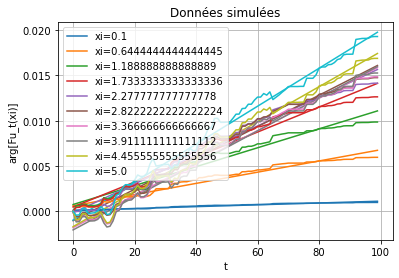

In [13]:
draw_log_arg(wt_sim_norm,ximin=0.1,ximax=5,nbreaks_xi=10,tmax=100,titre="Données simulées renormalisées")
draw_log_arg(wt_sim,ximin=0.1,ximax=5,nbreaks_xi=10,tmax=100,titre="Données simulées")

$\to$ correspondance potable des pentes

pente : 0.00022571265064462133
pente : 0.00020894776348786412
pente : 0.00017406674079336278
pente : 0.00018077740816216446
pente : 0.00025942998122612773


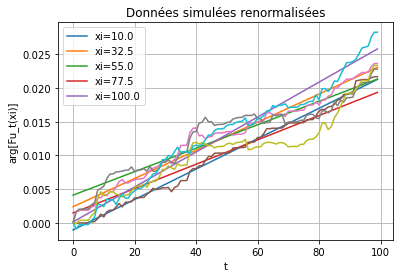

pente : 0.00019198610787257557
pente : 0.00777118901088362
pente : -0.000589793151109622
pente : -0.0008397462670190477
pente : 0.0003766630111038517


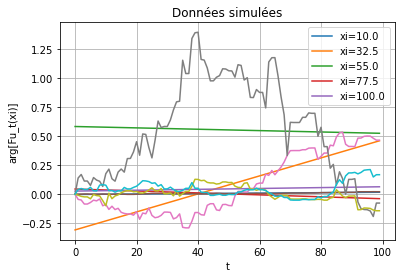

In [14]:
draw_log_arg(wt_sim_norm,ximin=10,ximax=100,nbreaks_xi=5,tmax=100,titre="Données simulées renormalisées")
draw_log_arg(wt_sim,ximin=10,ximax=100,nbreaks_xi=5,tmax=100,titre="Données simulées")

$\to$ pentes toujours pas potables pour les grandes valeurs de $\xi$

# Conclusion

Si on ne considère que les petites valeurs de $\xi$: la correspondance entre les données normalisées et les données non normalisées est très bonne (en principe, les pentes devraient être identiques).

Si on considère les grandes valeurs de $\xi$: on n'obtient plus de droite pour les données non normalisées. C'est mystérieux: erreur dans les calculs ? erreur dans le code ? erreur d'approximation ?

On obtient, tout de même, de belles droites pour les données normalisées. Cependant, on ne peut pas normaliser les données réelles car l'erreur devient trop grande.